# Performance Analysis

This notebook evaluates the trained house-pricing model using predictions exported to `models/test_predictions.csv`. 
It generates visualizations and saves them in `reports/figures/`.


In [11]:

# --- 0) Setup & styling ---
import os, sys, math, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="notebook", style="whitegrid")

ROOT = Path(os.getcwd()).parent
FIG_DIR = ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

PRED_PATH = ROOT / "models" / "test_predictions.csv"
TEST_PATH = ROOT / "data" / "processed" / "test.csv"

def savefig(name, dpi=150, tight=True):
    path = FIG_DIR / name
    if tight:
        plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"Saved figure: {path}")


First we load our predictions and compute some metrics like RMSE, MAE, R2...

In [12]:

# --- 1) Load predictions and compute metrics ---
assert PRED_PATH.exists(), "models/test_predictions.csv not found. Run prediction first."
pred_df = pd.read_csv(PRED_PATH)

def rmse(y, yhat): return float(np.sqrt(np.mean((y - yhat)**2)))
def mae(y, yhat):  return float(np.mean(np.abs(y - yhat)))
def r2(y, yhat):
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return float(1 - ss_res/ss_tot) if ss_tot > 0 else np.nan
def mape(y, yhat, eps=1e-8):
    denom = np.maximum(np.abs(y), eps)
    return float(np.mean(np.abs((y - yhat) / denom))) * 100.0

metrics = {}
y = pred_df["y_true"].to_numpy()
yhat = pred_df["prediction"].to_numpy()
metrics = {"RMSE": rmse(y, yhat), "MAE": mae(y, yhat), "R2": r2(y, yhat), "MAPE(%)": mape(y, yhat)}
print(json.dumps(metrics, indent=2))

pred_df.head()


{
  "RMSE": 0.0697569582846658,
  "MAE": 0.0541609654672326,
  "R2": 0.9952813292838146,
  "MAPE(%)": 15.300234838595813
}


,prediction,y_true
0,0.999097,1.166766
1,-0.480355,-0.458998
2,1.336612,1.360370
3,1.671790,1.724290
4,0.652021,0.738827


Then, we make a scatter plot of the actual and predicted values

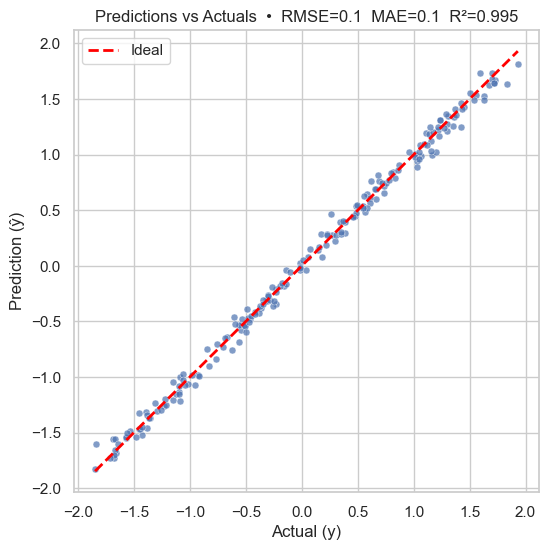

In [13]:

# --- 2) Scatter: Actual vs Predicted ---
plt.figure(figsize=(6,6))
ax = sns.scatterplot(x=pred_df["y_true"], y=pred_df["prediction"], alpha=0.7, s=25)
lo = float(min(pred_df["y_true"].min(), pred_df["prediction"].min()))
hi = float(max(pred_df["y_true"].max(), pred_df["prediction"].max()))
ax.plot([lo, hi], [lo, hi], linestyle="--", linewidth=2, color="red", label="Ideal")
ax.set(xlabel="Actual (y)", ylabel="Prediction (ŷ)")
ax.set_title(f"Predictions vs Actuals  •  RMSE={metrics.get('RMSE', float('nan')):.1f}  "
                f"MAE={metrics.get('MAE', float('nan')):.1f}  R²={metrics.get('R2', float('nan')):.3f}")
ax.legend()
plt.savefig("pred_vs_actual.svg")
plt.show()


We also create graphs showing the training and validation loss along our epochs

Saved figure: c:\Users\ikeru\OneDrive\Escritorio\UNI IKER\PROYECTOS\Software_Development\reports\figures\training_vs_validation_loss.svg


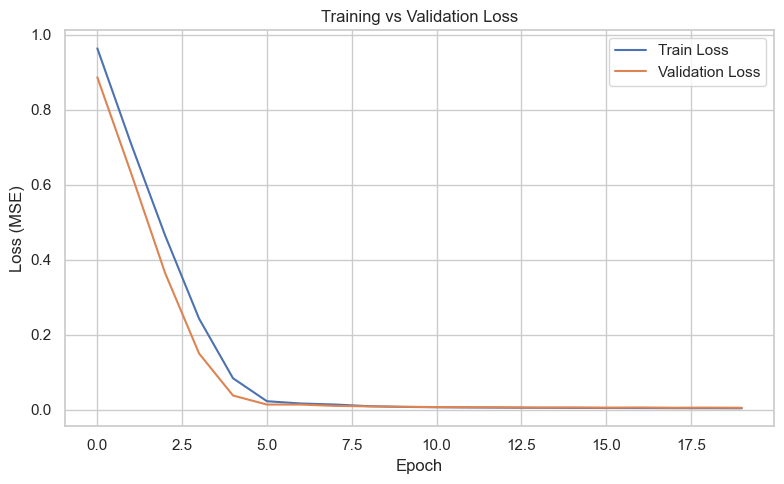

In [14]:

# --- 3) Training and Validation Loss ---

log_dir = "../reports/logs/house_price/version_1"  
metrics_path = os.path.join(log_dir, "metrics.csv")

df = pd.read_csv(metrics_path)

train_loss = df[df["train_loss"].notna()][["epoch", "train_loss"]]
val_loss = df[df["val_loss"].notna()][["epoch", "val_loss"]]

plt.figure(figsize=(8, 5))
plt.plot(train_loss["epoch"], train_loss["train_loss"], label="Train Loss")
plt.plot(val_loss["epoch"], val_loss["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
savefig("training_vs_validation_loss.svg")
plt.show()


# Extra Graphs

1) Residual Analysis

Saved figure: c:\Users\ikeru\OneDrive\Escritorio\UNI IKER\PROYECTOS\Software_Development\reports\figures\residuals_hist.svg


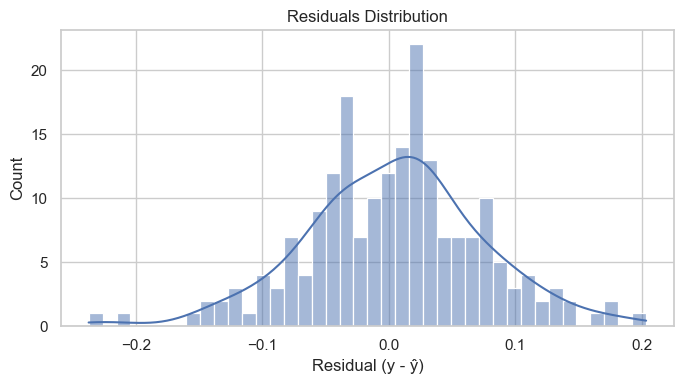

In [15]:

# --- 4) Residuals analysis ---
resid = pred_df["y_true"] - pred_df["prediction"]
pred_df["residual"] = resid
pred_df["abs_residual"] = resid.abs()

plt.figure(figsize=(7,4))
sns.histplot(resid, bins=40, kde=True)
plt.xlabel("Residual (y - ŷ)")
plt.ylabel("Count")
plt.title("Residuals Distribution")
savefig("residuals_hist.svg")
plt.show()

2) Absolute Error and MSE loss

,y_true,prediction,abs_error,mse_sample
0,-1.838099,-1.600519,0.237580,0.056444
1,0.257160,0.470601,0.213441,0.045557
2,1.836880,1.633286,0.203594,0.041450
3,1.201616,1.024541,0.177075,0.031356
4,1.422211,1.251396,0.170816,0.029178
5,1.166766,0.999097,0.167669,0.028113
6,0.617376,0.767338,0.149962,0.022489
7,-0.606567,-0.461446,0.145122,0.021060
8,1.632024,1.488386,0.143638,0.020632
9,1.596897,1.736722,0.139824,0.019551


Saved figure: c:\Users\ikeru\OneDrive\Escritorio\UNI IKER\PROYECTOS\Software_Development\reports\figures\absolute_error_vs_mse.svg


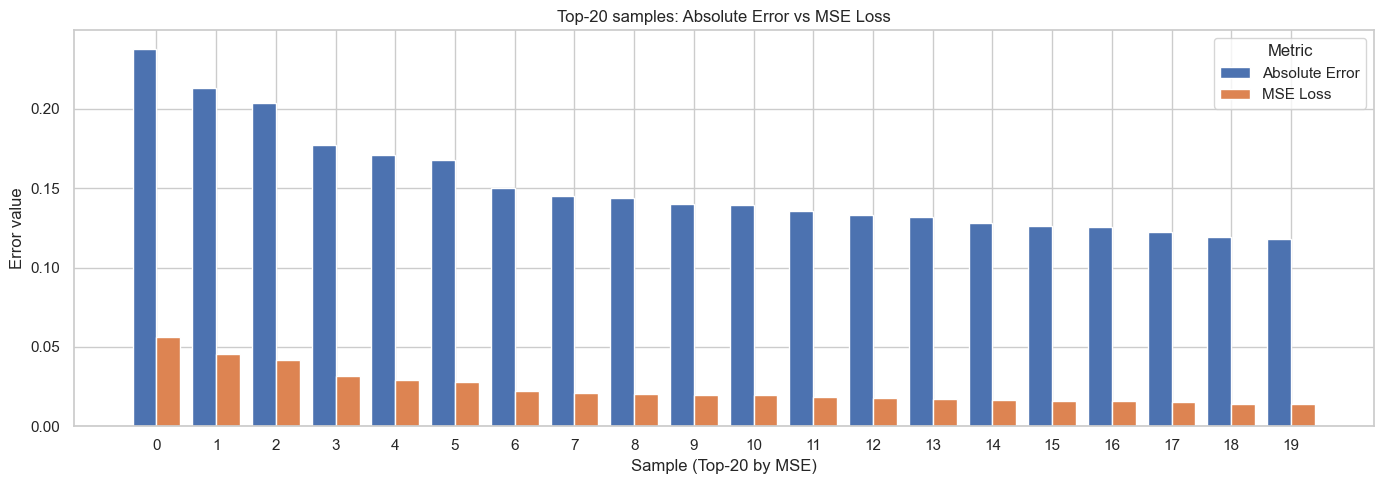

In [16]:
# --- 5) Absolute Error and MSE Loss ---

df_preds = pd.read_csv("../models/test_predictions.csv")

df_preds["abs_error"] = (df_preds["y_true"] - df_preds["prediction"]).abs()
df_preds["mse_sample"] = (df_preds["y_true"] - df_preds["prediction"])**2

worst_mse = df_preds.sort_values("mse_sample", ascending=False).head(20).reset_index(drop=True)
display(worst_mse[["y_true", "prediction", "abs_error", "mse_sample"]])

sns.set_theme(style="whitegrid")
x = np.arange(len(worst_mse))
width = 0.4

plt.figure(figsize=(14, 5))
plt.bar(x - width/2, worst_mse["abs_error"], width=width, label="Absolute Error")
plt.bar(x + width/2, worst_mse["mse_sample"], width=width, label="MSE Loss")

plt.xlabel("Sample (Top-20 by MSE)")
plt.ylabel("Error value")
plt.title("Top-20 samples: Absolute Error vs MSE Loss")
plt.xticks(x, [str(i) for i in x])
plt.legend(title="Metric")
plt.tight_layout()
savefig("absolute_error_vs_mse.svg")
plt.show()


3) Error by Target quantiles

C:\Users\ikeru\AppData\Local\Temp\ipykernel_23752\4203490565.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = pred_df.assign(bin=bins).groupby("bin").apply(
C:\Users\ikeru\AppData\Local\Temp\ipykernel_23752\4203490565.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = pred_df.assign(bin=bins).groupby("bin").apply(


,count,RMSE,MAE
bin,,,
"(-1.8479999999999999, -1.06]",40.0,0.072360,0.056015
"(-1.06, -0.3]",40.0,0.060292,0.046375
"(-0.3, 0.46]",40.0,0.065803,0.050378
"(0.46, 1.114]",40.0,0.061473,0.048900
"(1.114, 1.931]",40.0,0.085732,0.069137


Saved figure: c:\Users\ikeru\OneDrive\Escritorio\UNI IKER\PROYECTOS\Software_Development\reports\figures\error_by_target_quantiles.svg


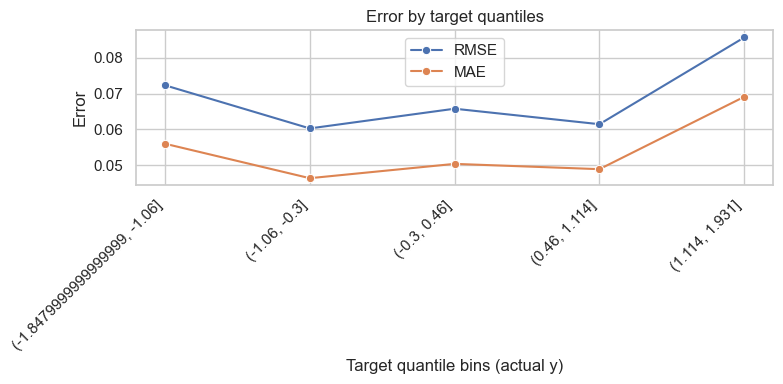

In [17]:

# --- 6) Error by target quantiles ---
bins = pd.qcut(pred_df["y_true"], q=5, duplicates="drop")
grouped = pred_df.assign(bin=bins).groupby("bin").apply(
    lambda g: pd.Series({
        "count": len(g),
        "RMSE": rmse(g["y_true"].to_numpy(), g["prediction"].to_numpy()),
        "MAE": mae(g["y_true"].to_numpy(), g["prediction"].to_numpy()),
    })
)
display(grouped)

plt.figure(figsize=(8,4))
sns.lineplot(x=np.arange(len(grouped)), y=grouped["RMSE"], marker="o", label="RMSE")
sns.lineplot(x=np.arange(len(grouped)), y=grouped["MAE"], marker="o", label="MAE")
plt.xticks(ticks=np.arange(len(grouped)), labels=[str(ix) for ix in grouped.index], rotation=45, ha="right")
plt.xlabel("Target quantile bins (actual y)")
plt.ylabel("Error")
plt.title("Error by target quantiles")
plt.legend()
savefig("error_by_target_quantiles.svg")
plt.show()


4) Error vs top-correlated features

Correlation with |error| (top 10):


Lot_Size                0.164081
Square_Footage          0.073471
Num_Bedrooms            0.071758
Num_Bathrooms          -0.059734
Neighborhood_Quality   -0.068815
Year_Built             -0.082721
Garage_Size            -0.101712
Name: abs_err, dtype: float64

Saved figure: c:\Users\ikeru\OneDrive\Escritorio\UNI IKER\PROYECTOS\Software_Development\reports\figures\abs_error_vs_top_features.svg


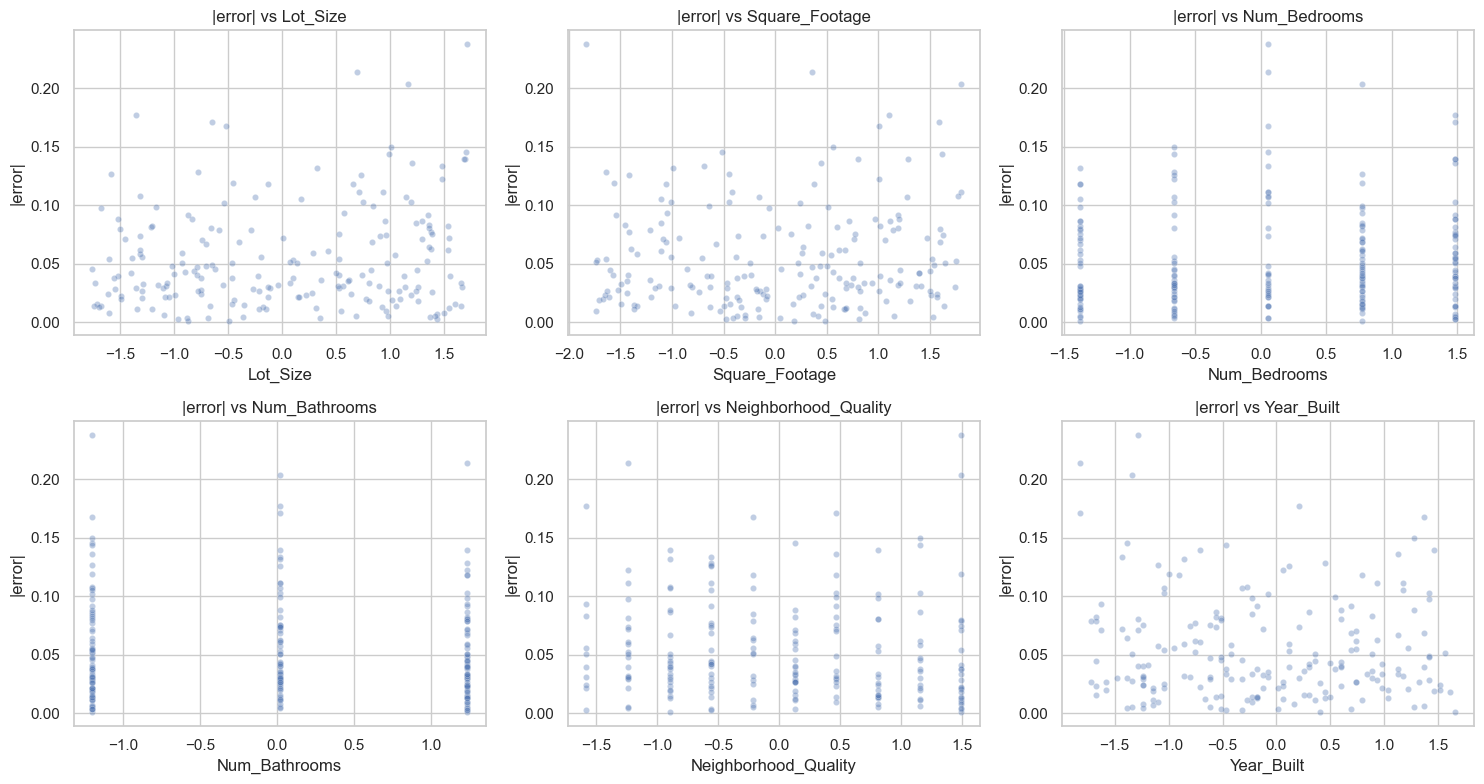

In [18]:

# --- 7) Error vs top-correlated features ---
test_df = pd.read_csv(TEST_PATH)
if len(test_df) == len(pred_df):
    merged = test_df.copy()
    merged["y_true"] = pred_df["y_true"].values
    merged["prediction"] = pred_df["prediction"].values
    merged["abs_err"] = (merged["y_true"] - merged["prediction"]).abs()

    num_cols = merged.select_dtypes(include=[np.number]).columns.tolist()
    for col in ["House_Price", "y_true", "prediction", "abs_err"]:
        if col in num_cols:
            num_cols.remove(col)

    if num_cols:
        corr = merged[num_cols + ["abs_err"]].corr(numeric_only=True)["abs_err"].drop("abs_err").sort_values(ascending=False)
        print("Correlation with |error| (top 10):")
        display(corr.head(10))

        top_show = corr.head(min(6, len(corr))).index.tolist()
        if top_show:
            n = len(top_show)
            ncols = min(3, n)
            nrows = int(np.ceil(n / ncols))
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
            axes = np.array(axes).reshape(-1) if isinstance(axes, np.ndarray) else [axes]
            for i, col in enumerate(top_show):
                sns.scatterplot(x=merged[col], y=merged["abs_err"], ax=axes[i], alpha=0.35, s=20)
                axes[i].set(xlabel=col, ylabel="|error|", title=f"|error| vs {col}")
            for j in range(i+1, len(axes)):
                axes[j].axis("off")
            plt.tight_layout()
            savefig("abs_error_vs_top_features.svg")
            plt.show()
